# Horse Rank Prediction by Classification

## 패키지 로드 & 옵션 정의

In [0]:
import numpy as np
import pandas as pd

pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/Colab Notebooks/race_result.csv" "race_result.csv"
#!cp "/content/drive/My Drive/Colab Notebooks/race.csv" "race.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 필요 함수 정의

In [0]:
from keras import backend as K

def print_shape(dfs):
    for df in dfs:
        print(df.shape)

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

## race_result 로드 & 기초 인코딩

In [0]:
result = pd.read_csv('race_result.csv')

# level 추가
#race = pd.read_csv('race.csv')
#tmp = race[['date', 'round', 'race_level']]
#tmp.level = tmp.race_level.apply(lambda x: None if not re.findall(r'\d+', x) else re.findall(r'\d+', x)[0])
#merged_result = result.merge(tmp, how='left', on=['date', 'round'])

result = result.iloc[::-1]  #~현재순서
result = result.reset_index().drop('index', axis=1)

# distance 대신 new_distance: 더미변수  # 1줄: scaling x, 2줄: scaling 할 변수
# race_level 결측치 너무 많음
result_df = result[ 
    ['rank', 'lane', 'sex', 'age','new_distance', 'prev1_rank', 'prev2_rank', 'prev3_rank', 'dandivi', 'yeondivi' ,
      'jockey_w', 'raw_weight', 'weight_added' , 'prev1_velo', 'prev2_velo', 'prev3_velo' ]
]  

#result_df = result[ 
#    ['rank', 'lane', 'sex', 'age','new_distance', 'prev1_rank', 'prev2_rank', 'prev3_rank', 'dandivi', 'yeondivi' ,
#      'jockey_w', 'raw_weight', 'weight_added']
#]  

# 결측치있는 raw 제거
result_nonan = result_df.dropna()

# sex 더미변수화
sex = pd.get_dummies(result_nonan.sex)
sex.columns = ['neut', 'male', 'female']
result_nonan = result_nonan.drop('sex', axis=1)
result_nonan = sex.join(result_nonan)

#display(result_nonan)

In [0]:
## standardize data

from sklearn import preprocessing

standadized_result = result_nonan[['jockey_w', 'raw_weight', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']]
scaler = preprocessing.StandardScaler().fit(standadized_result)
preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
result_nonan[['jockey_w', 'raw_weight', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']] = scaler.transform(standadized_result)

In [0]:
## normalize data

from sklearn import preprocessing

normalized_result = result_nonan[['jockey_w', 'raw_weight', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']]
result_nonan[['jockey_w', 'raw_weight', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']] = preprocessing.normalize(normalized_result)

In [0]:
## normalize data('jockey_w', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo') + standardize data('raw_weight')

from sklearn import preprocessing
normalized_result = result_nonan[['jockey_w', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']]
result_nonan[['jockey_w', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']] = preprocessing.normalize(normalized_result)

from scipy.stats import zscore
result_nonan[['raw_weight']] = result_nonan[['raw_weight']].apply(zscore)

In [0]:
# log scaling odds
#result_nonan[['dandivi', 'yeondivi']] = result_nonan[['dandivi', 'yeondivi']].apply(lambda x : np.log(x))

result_nonan[['dandivi', 'yeondivi']] = result_nonan[['dandivi', 'yeondivi']].replace([0.0], 1).apply(lambda x : np.log(x))

## -inf값 존재 문제 -> 0.0 을 1로 대체? => log(1) = 0

In [0]:
dan=result_nonan[result_nonan['yeondivi']>0]
dan['dandivi'].min()  #1.1
dan['yeondivi'].min() #1.0

0.0001

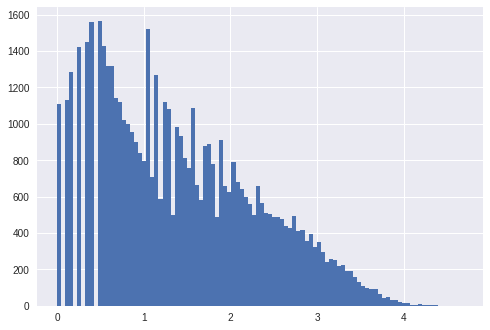

In [0]:
import matplotlib.pyplot as plt
#n, bins, patches = plt.hist(result_nonan['jockey_w'], bins=10)

plt.hist(result_nonan['jockey_w'], bins=100)      
#plt.hist(result_nonan['raw_weight'], bins=100)   
#plt.hist(result_nonan['weight_added'], bins=100)

#plt.hist(result_nonan['prev1_velo'], bins=100)

plt.show()

In [0]:
# 1~3등: 0, 나머지: 1
#ranks_replace = {
#    'rank': {'1': 0, '2': 0, '3': 0, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '10': 1, '11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '16': 1, '실': None, '제': None, '중': None, '취': None},
#    'prev1_rank' : {'실': None, '제': None, '중': None, '취': None},
#    'prev2_rank' : {'실': None, '제': None, '중': None, '취': None},
#    'prev3_rank' : {'실': None, '제': None, '중': None, '취': None},
#}
ranks_replace = {
    'rank': {'1': 1, '2': 1, '3': 1, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '실': None, '제': None, '중': None, '취': None},
    'prev1_rank' : {'실': None, '제': None, '중': None, '취': None},
    'prev2_rank' : {'실': None, '제': None, '중': None, '취': None},
    'prev3_rank' : {'실': None, '제': None, '중': None, '취': None},
}
result_binary = result_nonan.replace(ranks_replace, inplace=False)
result_binary = result_binary.dropna()

result_binary['prev1_rank'] = pd.to_numeric(result_binary['prev1_rank'])
result_binary['prev2_rank'] = pd.to_numeric(result_binary['prev2_rank'])
result_binary['prev3_rank'] = pd.to_numeric(result_binary['prev3_rank'])

# prev_rank 평균
#result_binary['prev_rank_mean'] = (result_binary['prev1_rank']+result_binary['prev2_rank']+result_binary['prev3_rank'])/3
#result_binary = result_binary.drop('prev1_rank', axis=1)
#result_binary = result_binary.drop('prev2_rank', axis=1)
#result_binary = result_binary.drop('prev3_rank', axis=1)

#display(result_binary.shape, result_binary.dtypes)

In [0]:
rank = result_binary['rank']
result_binary.drop(labels=['rank'], axis=1,inplace = True)
result_binary.insert(0, 'rank', rank)

In [0]:
#result_binary.head()
result_binary.shape

(52036, 18)

## 학습데이터 분리

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(result_binary, test_size=0.2, shuffle=False, stratify=None)

x_train = train.iloc[:, 1:]
y_train = train['rank'].astype(int)

x_test = test.iloc[:, 1:]
y_test = test['rank'].astype(int)

#print_shape((x_train, y_train, x_test, y_test))
#display(x_train, y_train, x_test, y_test)

## NN 모델

In [0]:
!pip install keras_metrics

In [0]:
# 0. 사용할 패키지 불러오기
from keras.models import Sequential
from keras.layers import Dense
import keras_metrics
import keras
import random
from sklearn.utils import class_weight
from keras import callbacks
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
# 2. 모델 구성하기
xavier = keras.initializers.glorot_normal(seed=None)

# Early stopping  
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
#early_stop = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

model = Sequential()
#model.add(Dense(128, input_dim=16, kernel_initializer='normal', activation='relu'))
#model.add(Dense(128, kernel_initializer='normal', activation='relu'))
#model.add(Dense(64, input_dim=17, kernel_initializer=xavier, activation='relu'))
model.add(Dense(32, input_dim=17, kernel_initializer=xavier, activation='relu'))
#model.add(Dropout (0.2))   # Dropout(): fraction of neurons to drop
model.add(Dense(16, input_dim=17, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# history = model.fit(X, Y, validation_split=0.33, epochs=1000, batch_size=10, verbose=0, callbacks=[tb, early_stop])

In [0]:
# 3. 모델 학습과정 설정하기
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [0]:
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])   #recall, precision

# 4. 모델 학습시키기
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)  # balanced = n_samples / (n_classes * np.bincount(y))
#class_weight = {0 : 1.1, 1: 1.4}

#hist = model.fit(x_train, y_train, epochs=1000, batch_size=10, verbose=0, callbacks=[early_stop])
hist = model.fit(x_train, y_train, epochs=1000, class_weight=class_weights)
# model.fit(X_train, Y_train, nb_epoch=5, batch_size=32, class_weight=class_weight)

Epoch 1/1000
41628/41628 [==============================] - 2s 56us/step - loss: 0.4738 - acc: 0.7709
Epoch 2/1000
41628/41628 [==============================] - 1s 36us/step - loss: 0.4632 - acc: 0.7801
Epoch 3/1000
41628/41628 [==============================] - 1s 36us/step - loss: 0.4605 - acc: 0.7798
Epoch 4/1000
41628/41628 [==============================] - 1s 36us/step - loss: 0.4588 - acc: 0.7808
Epoch 5/1000
41628/41628 [==============================] - 1s 35us/step - loss: 0.4577 - acc: 0.7812
Epoch 6/1000
41628/41628 [==============================] - 1s 36us/step - loss: 0.4575 - acc: 0.7824
Epoch 7/1000
41628/41628 [==============================] - 1s 36us/step - loss: 0.4562 - acc: 0.7825
Epoch 8/1000
41628/41628 [==============================] - 2s 36us/step - loss: 0.4558 - acc: 0.7832
Epoch 9/1000
41628/41628 [==============================] - 1s 36us/step - loss: 0.4551 - acc: 0.7837
Epoch 10/1000
41628/41628 [==============================] - 1s 35us/step - loss: 

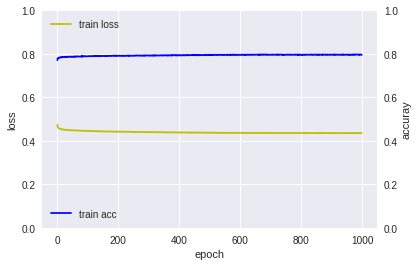

10408/10408 [==============================] - 0s 23us/step
loss_and_metrics : [0.5039754215338704, 0.7496156802459646]


In [0]:
# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

## 허용치 설정 후 precision 계산

In [0]:
pred = model.predict(x_test)
yt = np.array(y_test)
predictions = [0 for x in range(pred.shape[0])]
for i, predicted in enumerate(pred):
    if predicted[0] > 0.8:
        predictions[i] = 1
    else:
        predictions[i] = 0
        
df = pd.DataFrame({'prediction' : predictions, 'real' : yt})
df['accurate'] = df['prediction'] == df['real']

display(
    df[df['prediction'] == 1].shape[0] / df.shape[0],
    df[df['prediction'] == 1].accurate.mean()
)

FailedPreconditionError: ignored